# Average Nighttime Public Transport Service Frequency in London MSOAs（per stop)

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from shapely.geometry import Point
import datetime

# Functions: Handling non-standard time formats
def handle_nonstandard_times(time_str):
    if time_str:
        hours, minutes, seconds = map(int, time_str.split(':'))
        # Adjustments over 23 hours
        if hours >= 24:
            hours -= 24
        return datetime.time(hours, minutes, seconds)
    return None

In [2]:
# Loading stop_times.txt
stop_times_df = pd.read_csv('stop_times.txt')

In [3]:
# Applying time processing functions
stop_times_df['arrival_time'] = stop_times_df['arrival_time'].apply(handle_nonstandard_times)

In [4]:
# Filtering the data for the night time period (11pm-5am) and de-emphasising the sites within each trip_id
nighttime_stop_times = stop_times_df[stop_times_df['arrival_time'].apply(lambda x: datetime.time(23, 0) <= x or x <= datetime.time(5, 0))]
unique_nighttime_stops = nighttime_stop_times.drop_duplicates(subset=['trip_id', 'stop_id'])


In [5]:
# Calculate the frequency of night service at each site
nighttime_frequency = unique_nighttime_stops.groupby('stop_id').size().reset_index(name='nighttime_frequency')


In [6]:
# Load stops.txt and convert to GeoDataFrame
stops_df = pd.read_csv('stops.txt')
stops_gdf = gpd.GeoDataFrame(
    stops_df,
    geometry=gpd.points_from_xy(stops_df['stop_lon'], stops_df['stop_lat']),
    crs='EPSG:4326'
)

In [7]:
# Consolidation of night service frequencies into site data
stops_gdf = stops_gdf.merge(nighttime_frequency, on='stop_id', how='left')


In [8]:
# Loading MSOA boundary data
msoa_gdf = gpd.read_file('MSOA_2011_London_gen_MHW.shp')
msoa_gdf = msoa_gdf.to_crs('EPSG:4326')

In [9]:
# spatial connection
stops_with_msoa = gpd.sjoin(stops_gdf, msoa_gdf, how='left', predicate='within')


In [10]:
# Ensure that each site is counted only once per MSOA region
unique_stops_with_msoa = stops_with_msoa.drop_duplicates(subset=['MSOA11CD', 'stop_id'])

# Calculate total night service frequency and number of unique stations for each MSOA region
frequency_and_count_per_msoa = unique_stops_with_msoa.groupby('MSOA11CD').agg(
    total_nighttime_frequency=pd.NamedAgg(column='nighttime_frequency', aggfunc='sum'),
    stop_count=pd.NamedAgg(column='stop_id', aggfunc='nunique')
).reset_index()


In [11]:
# Calculate the average frequency per site per night
frequency_and_count_per_msoa['average_frequency_per_stop'] = frequency_and_count_per_msoa['total_nighttime_frequency'] / frequency_and_count_per_msoa['stop_count']


In [12]:
# Merge calculations into MSOA data
msoa_gdf_with_frequency = msoa_gdf.merge(frequency_and_count_per_msoa[['MSOA11CD', 'average_frequency_per_stop']], on='MSOA11CD', how='left')
msoa_gdf_with_frequency['average_frequency_per_stop'] = msoa_gdf_with_frequency['average_frequency_per_stop'].fillna(0)


In [13]:
# Define discrete intervals for classifying service frequencies
frequency_bins = [0, 50, 100, 150, 200, 250, 300,350,400, max(msoa_gdf_with_frequency['average_frequency_per_stop'])]
msoa_gdf_with_frequency['frequency_category'] = pd.cut(msoa_gdf_with_frequency['average_frequency_per_stop'], bins=frequency_bins, include_lowest=True)

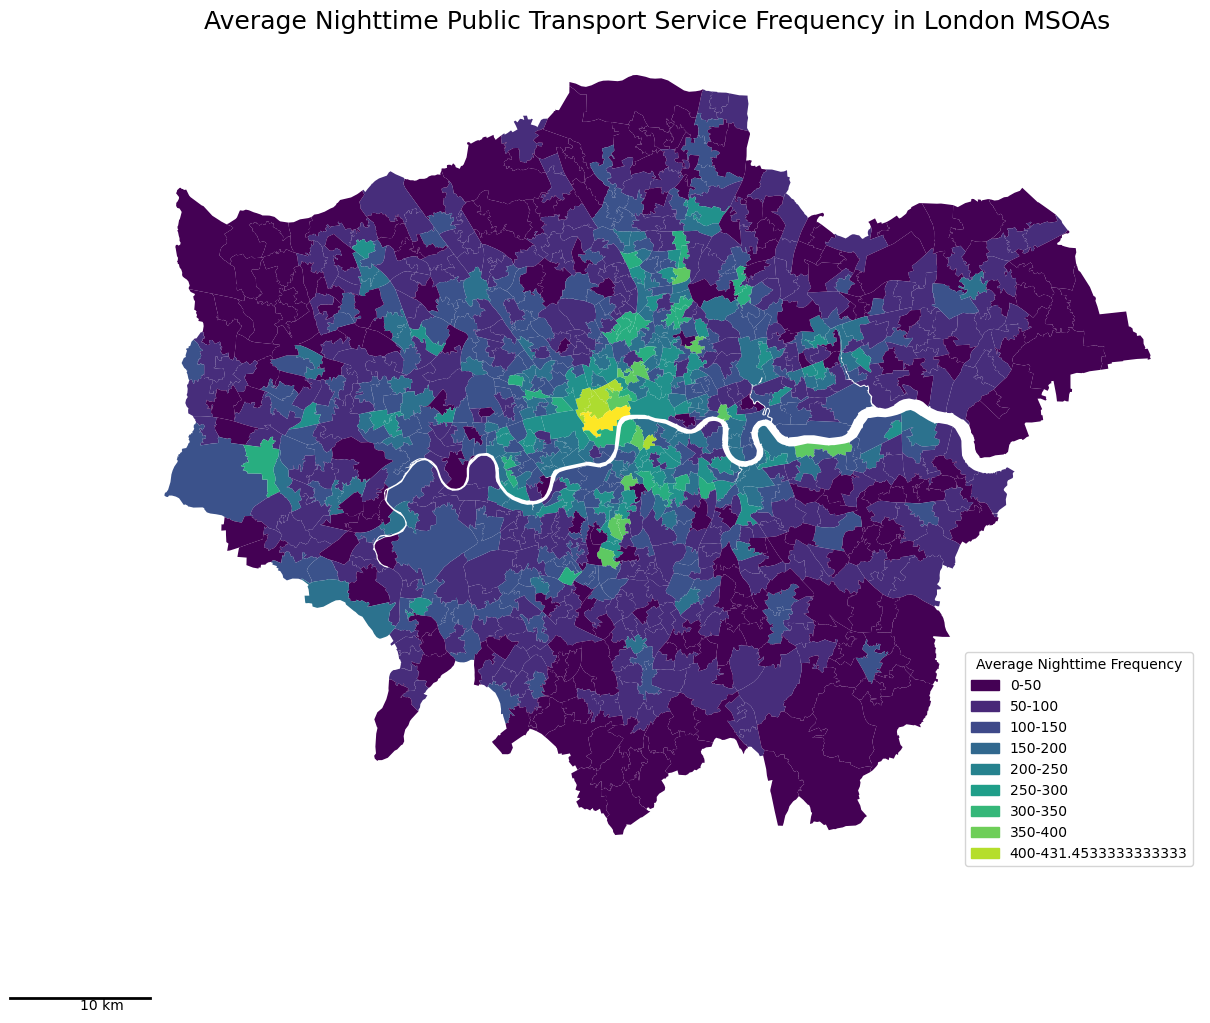

In [24]:
# Creating visualisations
fig, ax = plt.subplots(1, 1, figsize=(14, 12), dpi=100)
msoa_gdf_with_frequency.plot(column='frequency_category', cmap='viridis', ax=ax)

# Adding a custom legend
legend_labels = [f'{frequency_bins[i]}-{frequency_bins[i+1]}' for i in range(len(frequency_bins)-1)]
legend_colors = [plt.cm.viridis(i/(len(frequency_bins)-1)) for i in range(len(frequency_bins)-1)]
legend_patches = [Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_patches, title='Average Nighttime Frequency', loc='lower right')

# Adding a simplified scale
scale_line = mlines.Line2D([0.05, 0.15], [0.05, 0.05], color='black', transform=fig.transFigure, lw=2)
fig.lines.extend([scale_line])

# Scale of labelling
plt.text(0.1, 0.04, '10 km', transform=fig.transFigure)

# Setting the title and removing axes
ax.set_title('Average Nighttime Public Transport Service Frequency in London MSOAs', fontsize=18)
ax.axis('off')

plt.show()

In [15]:
# Population data loaded
file_msoa_population_data = 'msoa-data.csv' 
msoa_population_df = pd.read_csv(file_msoa_population_data, encoding='ISO-8859-1')

In [16]:
# Rename columns in msoa_population_df
msoa_population_df = msoa_population_df.rename(columns={'Middle Super Output Area': 'MSOA11CD'})

In [17]:
# Now try to merge
merged_data = msoa_gdf_with_frequency.merge(msoa_population_df, on='MSOA11CD')


In [18]:
# Load datasets
file_shp = 'MSOA_2011_London_gen_MHW.shp'
# Loading Shapefile Data
msoa_boundary = gpd.read_file(file_shp)
# Calculate the area of each MSOA region (square kilometres)
msoa_boundary['area_sq_km'] = msoa_boundary.to_crs(epsg=27700).area / 1e6

In [19]:
# calculate the population density and prepare to plot the Lorenz curve
merged_data['population_density'] = merged_data['Age Structure (2011 Census);All Ages;'] / msoa_boundary['area_sq_km']


In [20]:
# Prepare the data for the Lorentz curve
sorted_df = merged_data.sort_values(by='average_frequency_per_stop')
sorted_df['cum_stop_frequency_density'] = np.cumsum(sorted_df['average_frequency_per_stop']) / sorted_df['average_frequency_per_stop'].sum()
sorted_df['cum_population_density'] = np.cumsum(sorted_df['population_density']) / sorted_df['population_density'].sum()


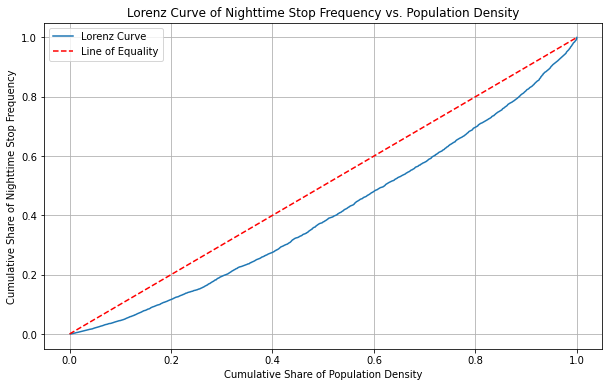

In [21]:
# Plotting the Lorentz curve
plt.figure(figsize=(10, 6))
plt.plot(sorted_df['cum_population_density'], sorted_df['cum_stop_frequency_density'], label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Line of Equality')
plt.title('Lorenz Curve of Nighttime Stop Frequency vs. Population Density')
plt.xlabel('Cumulative Share of Population Density')
plt.ylabel('Cumulative Share of Nighttime Stop Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Calculate the area under the Lorentz curve
area_under_lorenz_curve = np.trapz(sorted_df['cum_stop_frequency_density'], sorted_df['cum_population_density'])

# Calculation of the Gini coefficient
gini_coefficient = 1 - 2 * area_under_lorenz_curve

print("Gini Coefficient:", gini_coefficient)

Gini Coefficient: 0.18643809790937937
